# Excercise 3

### Team 11
- Lukas Burtscher
- Lukas Mahler
- Florian Dedov
- Dante Godolja

### Questions
- How do city quality of life rankings change over time?
- How do these rankings correlate with each other?
- How do they correlate with statistics about the countries in which the cities are found?
- How do they correlate with the cost of living?
- What are the determining characteristics of the livability of a city?



In [1]:
#imports
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import functools
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
import seaborn as sns

from mplsoccer import Bumpy
import highlight_text


## Question 1

#### Datasets

The most challenging part of this question was to obtain and collect ranking data from different publishers released in different years to observe the data over some time. The Global Liveability Index released in the Economist Intelligence Unit was the main source for this exercise. The yearly released liveability reports are not open source, thus we had to collect the data from the free overview brochures. Fortunately, the report of 2015 was completely free to use. For the collection process, we extracted the data out of PDFs into .csv data. The same process was applied for the Mercer liveability ranking released in 2019. Moreover, we were able to get our hands on two liveability datasets from https://www.kaggle.com/. 

In [2]:
#load liveabilty ranking data
liveability_2015_eiu = pd.read_csv('data/liveability-data/liveability-eiu-2015.csv', sep=',')
liveability_2019_eiu = pd.read_csv('data/liveability-data/liveability-eiu-2019-2.csv', sep=',')
liveability_2021_eiu = pd.read_csv('data/liveability-data/liveability-eiu-2021-2.csv', sep=',')
liveability_2020_teleport = pd.read_csv('data/liveability-data/liveability-detailed-2020-teleport.org.csv', sep=',')
liveability_2019_mercer = pd.read_csv('data/liveability-data/liveacbility-mercer-2019.csv', sep='\t', header=None, names=['Rank', 'City', 'Country'])
liveability_2017_movehub = pd.read_csv('data/liveability-data/movehubqualityoflife.csv', sep=',')

#### The Global Liveability Index
As this ranking is widely used and considered reliable this index is a very important source for our analysis. Because we collected the data on ourselves from their brochures we did not have missing values in the data. The Index provides us with a ranking, stability, healthcare, culture, education, and infrastructure score for each city. 100 is the highest score a city can achieve and according to their overall score cities are sorted in descending order.

To create time series insights, we hat to inner join all EIU rankings we had to see the changes over time for each entry. 
For the first plot we just want to observe the position changes in the rankings, therefore we kept the position column and brought them in connection to the year this score was hit.

Our Dataframe consists of cities either performing very well or bad in those rankings.


In [3]:
#no missing data and no outliers
#filter datasets to only consider cities appearing in all rankings
#liveability_2015_eiu
#liveability_2019_eiu


liveability_eiu = pd.merge(liveability_2015_eiu, liveability_2019_eiu, how ='inner', on =['Country', 'City'],suffixes=('_2015', '_2019'))
liveability_eiu = pd.merge(liveability_eiu, liveability_2021_eiu, how ='inner', on =['Country', 'City'])
liveability_eiu_ranking = liveability_eiu[['Country', 'City','Rank_2015', 'Rank_2019', 'Rank']]
liveability_eiu_ranking.rename(columns={'Rank_2015': '2015', 'Rank_2019': '2019', 'Rank': '2021'}, inplace=True)
liveability_eiu_ranking = liveability_eiu_ranking.T
liveability_eiu_ranking.columns = liveability_eiu_ranking.iloc[1]
liveability_eiu_ranking = liveability_eiu_ranking.iloc[2:]


liveability_eiu_ranking.head()

#liveability_eiu_ranking_top = liveability_eiu_ranking.iloc[0:4]
#liveability_eiu_ranking_bottom = liveability_eiu_ranking.iloc[4::]
#liveability_eiu_ranking_bottom

C:\Users\flori\anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


City,Melbourne,Adelaide,Tokyo,Osaka,Caracas,Douala,Harare,Algiers,Karachi,Tripoli,Lagos,Port Moresby,Dhaka,Damascus
2015,1,5,15,17,123,131,133,134,134,136,137,138,139,140
2019,2,10,7,4,131,133,134,132,136,137,139,135,138,140
2021,8,3,4,2,131,132,133,136,134,135,139,138,137,140


In [4]:
time = liveability_eiu_ranking.index.tolist()

highlight_dict = {
    'Melbourne':'#F2A000', 
    'Adelaide':'#00C500', 
    'Tokyo':'#8D4E42', 
    'Osaka':'#74D5F5',
    'Caracas':'#EBA979',
    'Douala':'#6DBEA0',
    'Harare':'#E8543A',
    'Algiers':'#163C5A',
    'Karachi':'#F2A000',
    'Tripoli':'#FF0000',
    'Lagos':'#A9D0DF',
    'Port Moresby':'#F1D9CB',
    'Dhaka':'#D5D5D5',
    'Damascus':'#B54EAF',
    'Overall Rating':'#F2A000', 
    'Stability':'#00C500', 
    'Healthcare':'#8D4E42', 
    'Culture and Environment':'#74D5F5',
    'Education':'#EBA979',
    'Infrastructure':'#6DBEA0',
    'Vienna':'#4edaf2',
    'Perth':'#d12ac3',
    'Sydney':'#8fe084',
    'Auckland':'#cff0b6',
    'Frankfurt':'#e08282'
}

bumpy = Bumpy(
    scatter_color = '#282828', line_color = '#4a4d4b',
    rotate_xticks=90,
    ticklabel_size=15,
    scatter_primary='D',
    show_right=True,
    plot_labels=True,
    alignment_yvalue=.1,
    alignment_xvalue=.065
    
)

### Plot Prosition changes

As we can see the ranking of the top cities is very competitive and the cities change their positions nearly every year. Osaka performed well within the last years, regarding the position it was ranked back in 2015 the city improved a lot and is ranked on place 2 for this year. It is interesting to see how Melbourne lost 6 places and Adelaide won 7 places in just one year.

Regarding the changes, the ranking seems to be very volatile and I would assume cities are not weighted on historic factors because cities that were solid for long periods can lose their good position within a year.

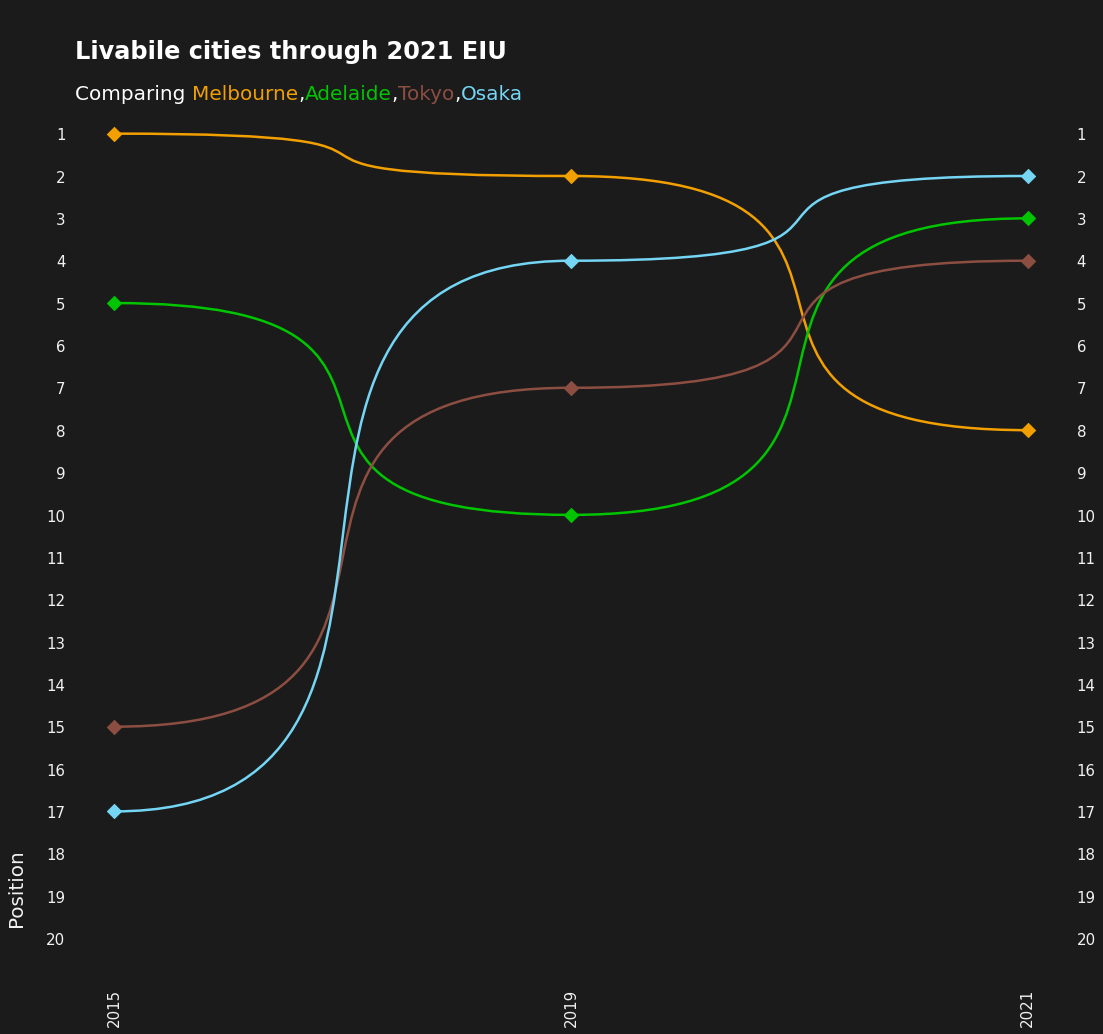

In [5]:
fig, ax = bumpy.plot(
    x_list = time, y_list = np.linspace(1,20,20).astype(int),
    values = liveability_eiu_ranking.iloc[0:4],
    secondary_alpha = .5,
    figsize = (18,18),
    y_label = 'Position',
    ylim = (-.1,23),
    lw = 2.5,
    highlight_dict = highlight_dict
    
)
fig.text(s = 'Livabile cities through 2021 EIU', x=.13, y=.84,
        c = 'white', size=24, weight='bold')

highlight_text.fig_text(x=.13, y=.82, s ='Comparing <Melbourne>,<Adelaide>,<Tokyo>,<Osaka>',
                       highlight_textprops = [
                           {'color':'#F2A000'},
                           {'color':'#00C500'},
                           {'color':'#8D4E42'},
                           {'color':'#74D5F5'}
                       ], fontsize = 20,
                       color = 'white',
                       )


Considering cities on the bottom of the ranking we observe that the situation is not that competitive and those cities stay on the same level for long periods. 
To give a reason for Caracas decrease I found an article https://www.bpb.de/internationales/weltweit/innerstaatliche-konflikte/266687/venezuela pointing out that the president elected in 2015 established an authoritative system.

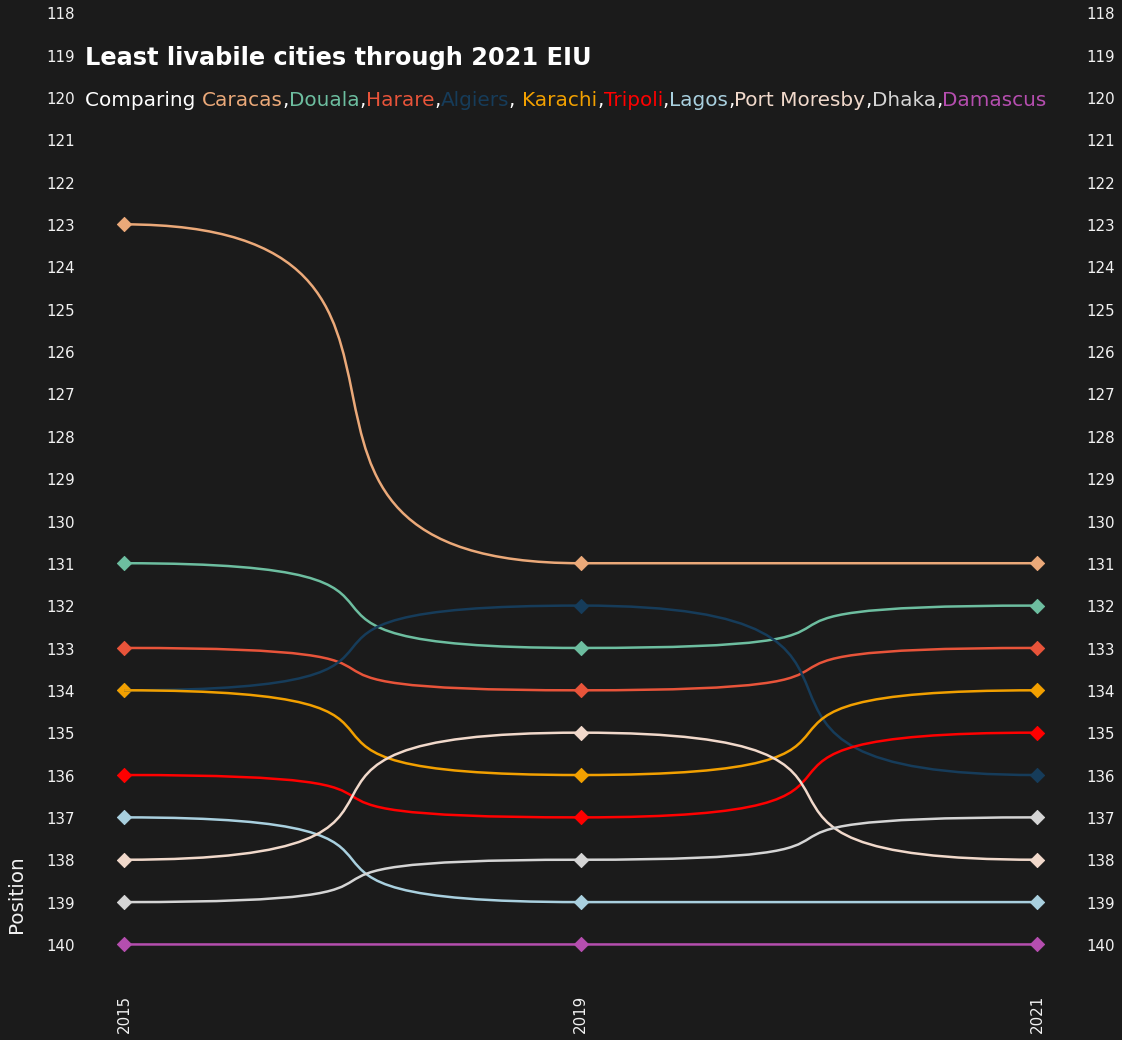

In [6]:
fig, ax = bumpy.plot(
    x_list = time, y_list = np.linspace(1,140,140).astype(int),
    values = liveability_eiu_ranking,
    secondary_alpha = .5,
    figsize = (18,18),
    y_label = 'Position',
    ylim = (-.1,23),
    lw = 2.5,
    highlight_dict = highlight_dict
    
)
fig.text(s = 'Least livabile cities through 2021 EIU', x=.13, y=.84,
        c = 'white', size=24, weight='bold')

highlight_text.fig_text(x=.13, y=.82, s ='Comparing <Caracas>,<Douala>,<Harare>,<Algiers>, <Karachi>,<Tripoli>,<Lagos>,<Port Moresby>,<Dhaka>,<Damascus>',
                       highlight_textprops = [
                           {'color':'#EBA979'},
                           {'color':'#6DBEA0'},
                           {'color':'#E8543A'},
                           {'color':'#163C5A'},
                            {'color':'#F2A000'},
                           {'color':'#FF0000'},
                           {'color':'#A9D0DF'},
                           {'color':'#F1D9CB'},
                           {'color':'#D5D5D5'},
                           {'color':'#B54EAF'},
                       ], fontsize = 20,
                       color = 'white',
                       )

#### City Insights

In the following part we want to focuss on Osaka and Melbourne to point out how one of them increased their score while the other city decreased.

As we cann see in the heatmap it seems that some factors like culture and education are not that crucial for a good rank as other factors like stability and infrastructure. After calculating the correlations for Melbourne, healthcare seems also to be a very crucial factor for the overall score.

Text(0.5, 1.0, 'Correlation Heatmap')

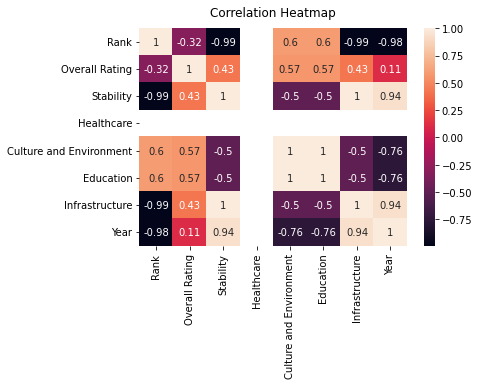

In [7]:

city_2015 = liveability_2015_eiu.loc[liveability_2015_eiu['City'] == 'Osaka']
city_2019 = liveability_2019_eiu.loc[liveability_2019_eiu['City'] == 'Osaka']
city_2021 = liveability_2021_eiu.loc[liveability_2021_eiu['City'] == 'Osaka']
city_osaka = pd.concat([city_2015, city_2019, city_2021])
city_osaka = city_osaka.dropna(axis=1)
city_osaka['Year'] = [2015,2019,2021]
city_corr_map = sns.heatmap(city_osaka.corr(), annot=True)
city_corr_map.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [8]:
city_2015 = liveability_2015_eiu.loc[liveability_2015_eiu['City'] == 'Melbourne']
city_2019 = liveability_2019_eiu.loc[liveability_2019_eiu['City'] == 'Melbourne']
city_2021 = liveability_2021_eiu.loc[liveability_2021_eiu['City'] == 'Melbourne']
city_melbourne = pd.concat([city_2015, city_2019, city_2021])
city_melbourne = city_melbourne.dropna(axis=1)
city_melbourne['Year'] = [2015,2019,2021]


In [9]:
city = city_osaka.set_index('Year')
city_data = city.drop(['Country','City', 'Rank'], axis=1)
city_data

,Overall Rating,Stability,Healthcare,Culture and Environment,Education,Infrastructure
Year,,,,,,
2015,94.5,90.0,100.0,93.5,100.0,92.9
2019,97.7,100.0,100.0,93.5,100.0,96.4
2021,94.2,100.0,100.0,83.1,91.7,96.4


As plotted down below we recognize a decrease in Culture, Environment, and Education while others seem to develop stably. However the overall ranking in the period from 2019 to 2021, thus it seems that competitors lost more dramatically in comparison to Osaka.

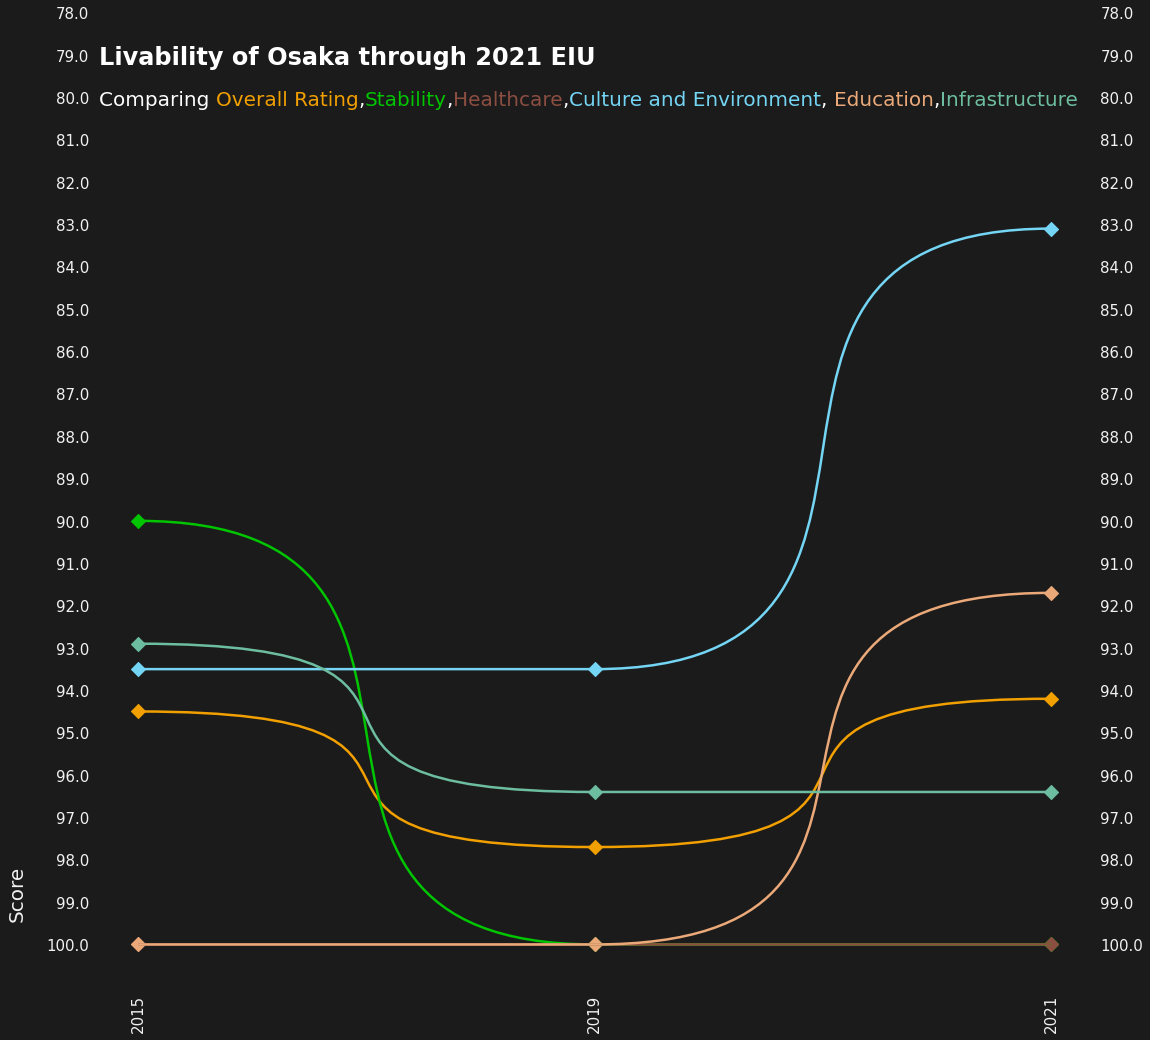

In [10]:
fig, ax = bumpy.plot(
    x_list = time, y_list = np.linspace(1,100,100).astype(float),
    values = city_data,
    secondary_alpha = .5,
    figsize = (18,18),
    y_label = 'Score',
    ylim = (-.1,23),
    lw = 2.5,
    highlight_dict = highlight_dict
    
)
fig.text(s = 'Livability of Osaka through 2021 EIU', x=.13, y=.84,
        c = 'white', size=24, weight='bold')

highlight_text.fig_text(x=.13, y=.82, s ='Comparing <Overall Rating>,<Stability>,<Healthcare>,<Culture and Environment>, <Education>,<Infrastructure>',
                       highlight_textprops = [
                           {'color':'#F2A000'},
                           {'color':'#00C500'},
                           {'color':'#8D4E42'},
                           {'color':'#74D5F5'},
                            {'color':'#EBA979'},
                           {'color':'#6DBEA0'},
                           
                       ], fontsize = 20,
                       color = 'white',
                       )

In [11]:

city = city_melbourne.set_index('Year')
city_data = city.drop(['Country','City', 'Rank'], axis=1)
city_data

,Overall Rating,Stability,Healthcare,Culture and Environment,Education,Infrastructure
Year,,,,,,
2015,97.5,95.0,100.0,95.1,100.0,100.0
2019,98.4,95.0,100.0,98.6,100.0,100.0
2021,92.5,95.0,83.3,88.2,100.0,100.0


In comparison to Osaka, we will now take a look at Melbourne. As shown down below Melbourne lost in healthcare while stability did not improve. both factors heavily correlate with the overall score, therefore Melbourne was placed under Osaka for this year's ranking. other factors, even Culture and Environment are higher than those of Osaka. Thus the score seems to heavily rely on stability and healthcare.

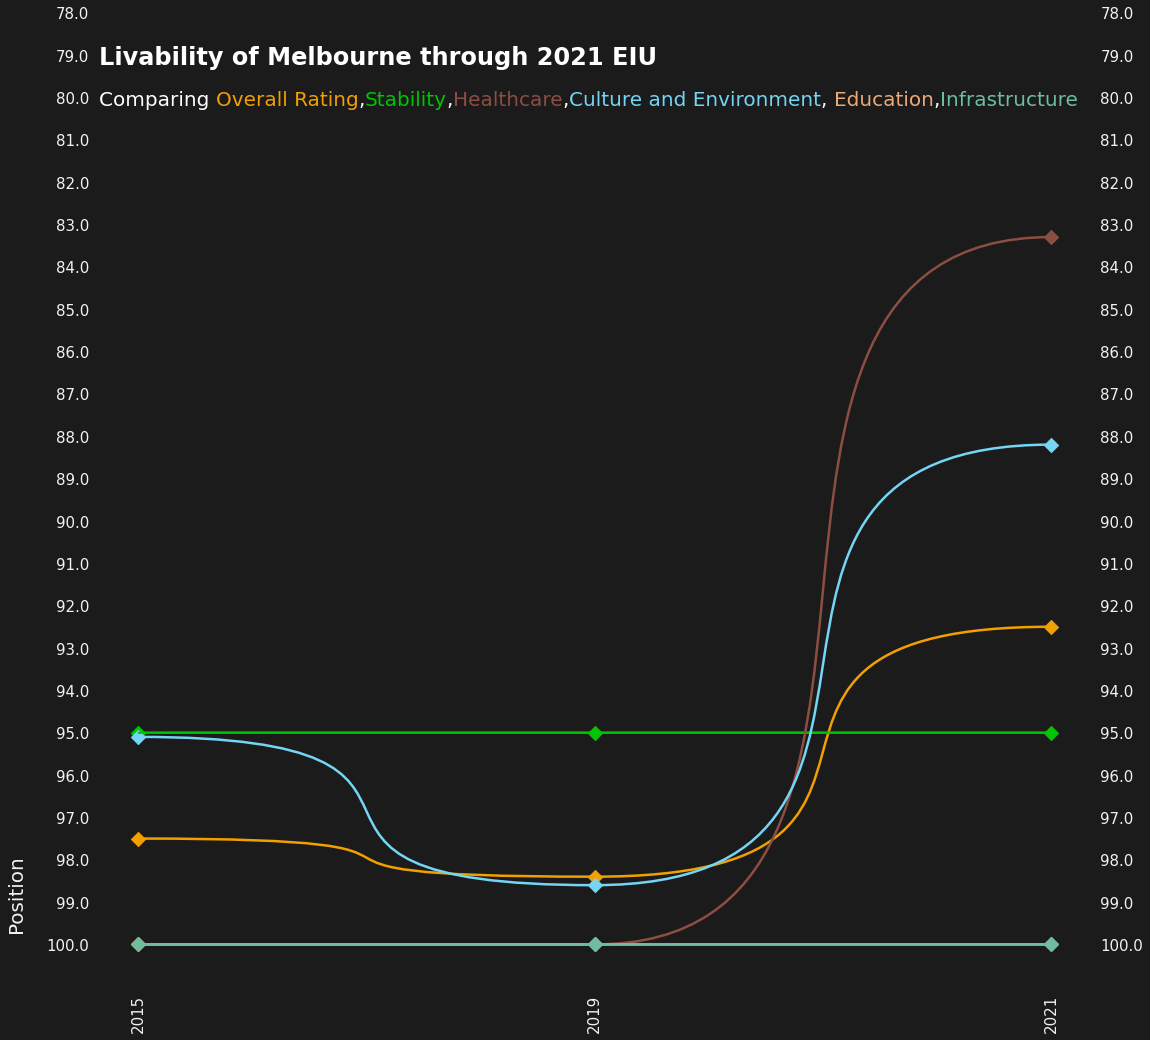

In [12]:
fig, ax = bumpy.plot(
    x_list = time, y_list = np.linspace(1,100,100).astype(float),
    values = city_data,
    secondary_alpha = .5,
    figsize = (18,18),
    y_label = 'Position',
    ylim = (-.1,23),
    lw = 2.5,
    highlight_dict = highlight_dict
    
)
fig.text(s = 'Livability of Melbourne through 2021 EIU', x=.13, y=.84,
        c = 'white', size=24, weight='bold')

highlight_text.fig_text(x=.13, y=.82, s ='Comparing <Overall Rating>,<Stability>,<Healthcare>,<Culture and Environment>, <Education>,<Infrastructure>',
                       highlight_textprops = [
                           {'color':'#F2A000'},
                           {'color':'#00C500'},
                           {'color':'#8D4E42'},
                           {'color':'#74D5F5'},
                            {'color':'#EBA979'},
                           {'color':'#6DBEA0'},
                           
                       ], fontsize = 20,
                       color = 'white',
                       )

#### Time Changes within different Publishers

In this part, we will analyze the differences between different rankings and observe the changes over time.
For this part, we merged the Movehub, Mercer, and EIU datasets and only focused on the ranking positions.

In [13]:
#build big ranking with different publisher
liveability_2017_movehub = liveability_2017_movehub.sort_values(by=['Movehub Rating'], ascending=False)
r = [i for i in range(1,len(liveability_2017_movehub.index)+1)]
liveability_2017_movehub['Rank'] = r
movehub_short = liveability_2017_movehub[['City', 'Rank']]
eiu_short = liveability_2015_eiu[['City', 'Rank']]
mercer_short = liveability_2019_mercer[['City', 'Rank']]

big_rating = pd.merge(eiu_short, movehub_short, how ='inner', on =['City'],suffixes=('_eiu_2015', '_movehub_2017'))
big_rating = pd.merge(big_rating, mercer_short, how ='inner', on =['City'])
big_rating.rename(columns={'Rank': 'Rank_mercer_2019'}, inplace=True)
big_rating = big_rating.set_index('City')
#big_rating.loc[big_rating['Rank_mercer_2019'] == 7]
big_rating = big_rating.T
#big_rating

The EIU and Mercer rankings seem much more comparable than the ranking of Movehub. The decrease of Melbourne discovered in the section above can be observed here as well, however, as we can see on Vienna and Frankfurt (and on the light gray lines representing cities) Movehub ranks cities in the top 10 that aren't ranked that high in the other rankings (Vienna place 97 in Movehub). Movehub seems to be d'accord for Australian cities because those are ranked nearly in the same places in all rankings. The differences between Movehub, EIU, Mercer, and Teleport will be pointed out in the further question.

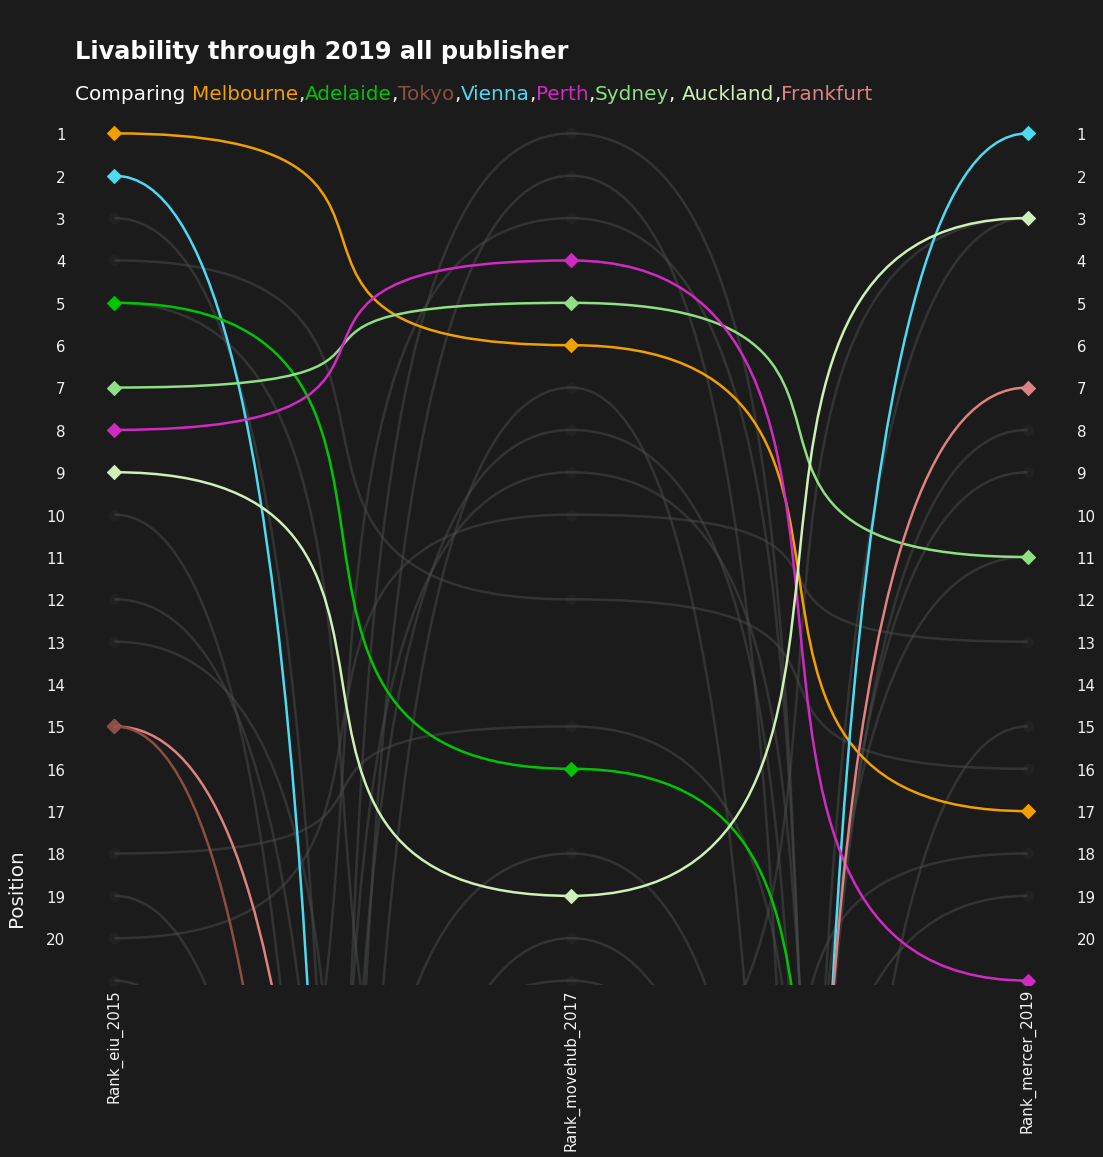

In [14]:
time_big = big_rating.index.tolist()

fig, ax = bumpy.plot(
    x_list = time_big, y_list = np.linspace(1,20,20).astype(int),
    values = big_rating,
    secondary_alpha = .5,
    figsize = (18,18),
    y_label = 'Position',
    ylim = (-.1,23),
    lw = 2.5,
    highlight_dict = highlight_dict
    
)
fig.text(s = 'Livability through 2019 all publisher', x=.13, y=.84,
        c = 'white', size=24, weight='bold')

highlight_text.fig_text(x=.13, y=.82, s ='Comparing <Melbourne>,<Adelaide>,<Tokyo>,<Vienna>,<Perth>,<Sydney>, <Auckland>,<Frankfurt>',
                       highlight_textprops = [
                           {'color':'#F2A000'},
                           {'color':'#00C500'},
                           {'color':'#8D4E42'},
                           {'color':'#4edaf2'},
                            {'color':'#d12ac3'},
                           {'color':'#8fe084'},
                           {'color':'#cff0b6'},
                           {'color':'#e08282'}
                           
                       ], fontsize = 20,
                       color = 'white',
                       )

### Changes over Time

to point out the changes in weighting the factors we observed the EIU rankings from 2015 and 2021.
We will focus on the overall rating because the rank is calculated by sorting the cities by the overall rating. As we can see stability became much more important to determine the overall score. Unfortunately for 2021, we were not able to collect data from more than 20 cities. Because of the data issue, we merged the 2019 and 2021 rankings to improve our sample data (the free EIU brochure only gives 20 cities).
However, the correlation map gives us the same insights. The only significant change that can be observed is the relationship between healthcare and stability as factors heavily influence the overall score.


Text(0.5, 1.0, 'EIU Correlation Heatmap 2021')

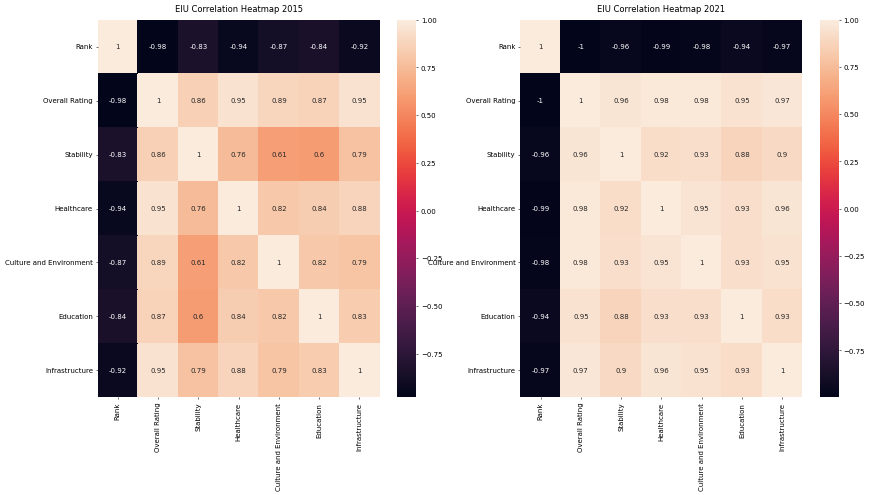

In [15]:
#plt.figure(figsize=(8, 6), dpi=80)
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=50)
#plt.figure(figsize=(8, 6), dpi=80)
corr_map = sns.heatmap(liveability_2015_eiu.corr(), annot=True, ax=axes[0])
corr_map.set_title('EIU Correlation Heatmap 2015', fontdict={'fontsize':12}, pad=12)
corr_map_new = sns.heatmap(liveability_2021_eiu.corr(), annot=True, ax=axes[1])
corr_map_new.set_title('EIU Correlation Heatmap 2021', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'EIU Correlation Heatmap 2019/21')

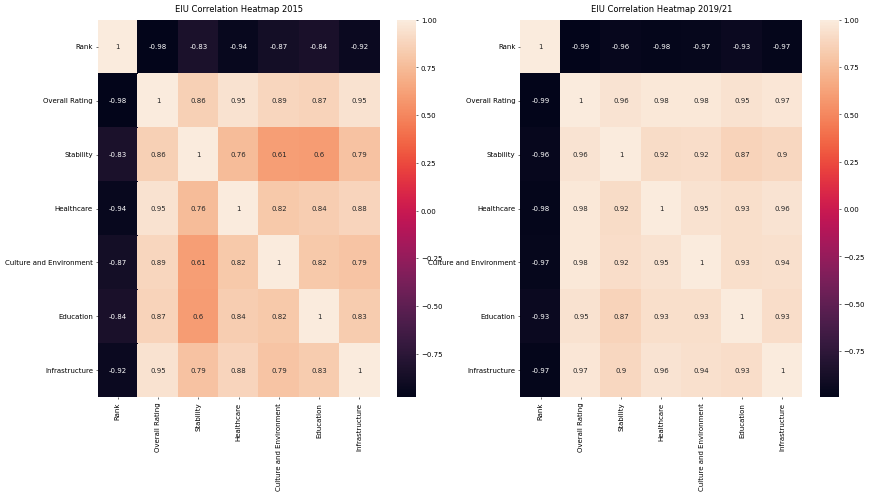

In [17]:

improved_eiu_data = pd.concat([liveability_2021_eiu, liveability_2019_eiu])
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=50)
#plt.figure(figsize=(8, 6), dpi=80)
corr_map = sns.heatmap(liveability_2015_eiu.corr(), annot=True, ax=axes[0])
corr_map.set_title('EIU Correlation Heatmap 2015', fontdict={'fontsize':12}, pad=12)
corr_map_new = sns.heatmap(improved_eiu_data.corr(), annot=True, ax=axes[1])
corr_map_new.set_title('EIU Correlation Heatmap 2019/21', fontdict={'fontsize':12}, pad=12)

## Question 2 


### Datasets

In order to answer this question, two comparisons are made. First the EIU ranking and the Mercer ranking for the year 2019 are compared. Here it is worth mentioning that the EIU ranking only lists 20 cities, whereas the Mercer ranking lists 231 cities. So the correlation, is less representative. Second, these two rankings are compared to the Movehub ranking. It is important to keep in mind that the Movehub ranking is for the year 2017, which means that a lower correlation may also be caused by the two year offset.

In [25]:
print(f"EIU: {len(liveability_2019_eiu)}, Mercer: {len(liveability_2019_mercer)}")

EIU: 20, Mercer: 231


### Correlation - EIU & Mercer

Since we only care about how the ranking correlate, all columns except for 'City' and 'Rank' are dropped. The two dataframes are then merged into a new one, with new suffixes given to the ranking columns.

In [37]:
eiu_2019 = liveability_2019_eiu[['City', 'Rank']]
mercer_2019 = liveability_2019_mercer[['City', 'Rank']]

In [38]:
combined = pd.merge(eiu_2019, mercer_2019, on='City', how='outer', suffixes=["_EIU", "_MERCER"])

Here, the correlation can already be calculated and visualized in a heatmap.

<AxesSubplot:>

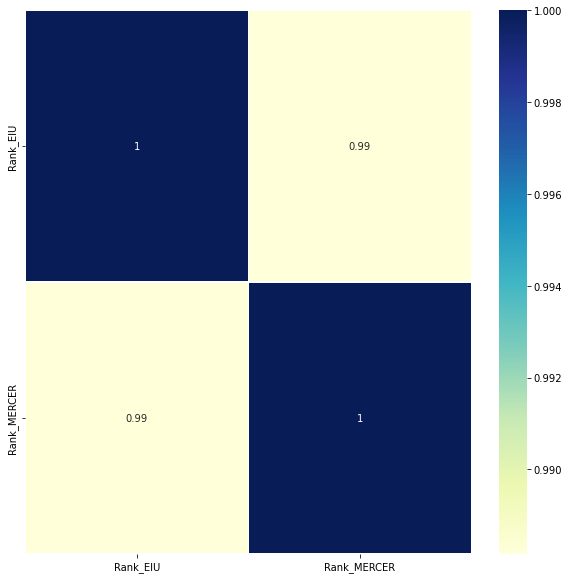

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(combined.corr(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

The correlation between the two rankings is 99%, which is very high. Even when we consider that we basically compared only 20 cities. Next, we added the Movehub ranking.

### Correlation - EIU, Mercer (2019) & Movehub (2017)

For this, we needed to apply the rank() method onto the rating column, since the dataset doesn't come with hierarchical ranks but with numerical ratings. After that, the dataset is merged into the combined dataset.

In [41]:
liveability_2017_movehub['Rank'] = liveability_2017_movehub['Movehub Rating'].rank(ascending=False)
movehub_2017 = liveability_2017_movehub[['City', 'Rank']]

combined_new = pd.merge(combined, movehub_2017, on="City", how="outer")
combined_new = combined_new.rename(columns={'Rank':'Rank_MOVEHUB'})

The correlation is again calculated and visualized.

<AxesSubplot:>

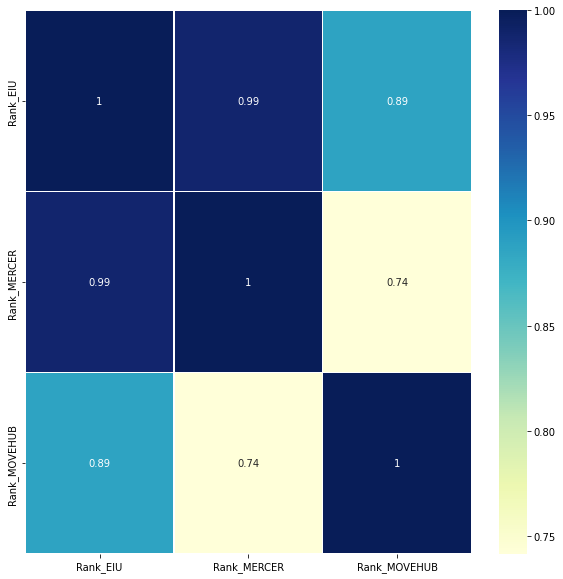

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(combined_new.corr(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

We can see that the correlation between the EIU (20 countries) and the Movehub (216) ranking is 89%, which is still pretty high. Especially when we consider that the two rankings are two years apart.

The Mercer ranking of 2019 and the Movehub ranking of 2017 have a correlation of 74%, which is also pretty high considering the time difference and also the amount of cities. In contrast to the correlation between EIU and Movehub and also EIU and Mercer, here we compare more than 20 cities. This of course makes it harder (or less likely) to have the same rankings.

In [43]:
print(f"EIU: {len(eiu_2019)}, Mercer: {len(mercer_2019)}, Movehub: {len(movehub_2017)}")

EIU: 20, Mercer: 231, Movehub: 216


All in all, we can say that the different rankings seem to be highly correlated, even if they are one or two years apart.

## Question 3

### Datasets

For this question, we need to use an additional dataset focusing on the statistics of countries, not cities. We use the world happiness report to get statistics about countries (GDP, Life Expectancy, Freedom etc.) and combine these with the Mercer ranking to see how strong the individual country statistics correlate with the city ranking.

In [66]:
happiness_report_2019 = pd.read_csv('data/Happiness-data/2019.csv', sep=',')

happiness_report_2019 = happiness_report_2019.rename(columns={"Country or region": "Country"})
mercer_2019 = liveability_2019_mercer[['City', 'Rank', 'Country']]

We rename the respective column and join the two data frames on the country column.

In [67]:
combined = pd.merge(happiness_report_2019, mercer_2019, on='Country', how='outer')

For this task, we want to ignore all the rows that are not present in both datasets. Thus, we drop the NaN rows. Also, we decide to drop the 'Overall rank' and the 'Score' of the country in the ranking, since it is not a statistic in and of itself, and we want to focus on the city ranks and the country statistics only.

In [68]:
combined = combined.dropna()
combined = combined.drop(['Overall rank', 'Score'], axis=1)

The correlations can then be visualized with a heatmap.

<AxesSubplot:>

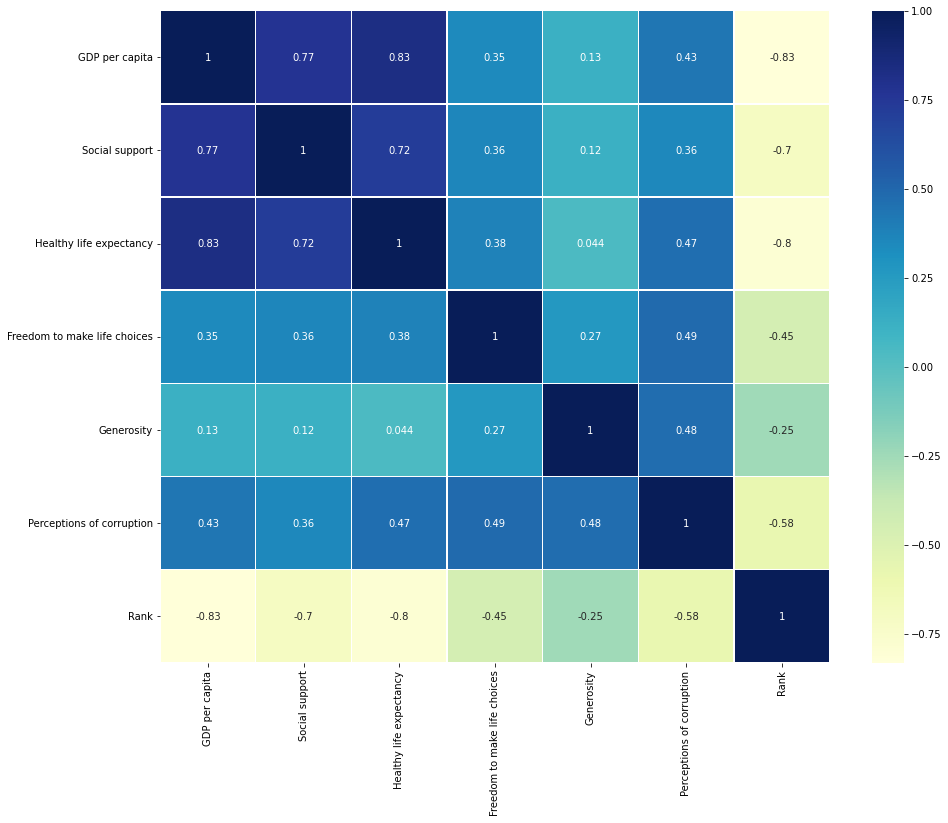

In [69]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(combined.corr(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

We can see that the rank of the cities is negatively correlated with all features. This makes sense, since these features are contributing to a better ranking and a better ranking results in a smaller number. The strongest correlation can be seen with the GDP per capita and the healthy life expectancy statistics. If the citizens of a country have a high healthy life expectancy and the GDP per capita is high, the individual cities inside of that country are also usually ranked higher.